In [4]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
import numpy as np # linear algebra
import pandas as pd
import tensorflow as tf
import keras_nlp

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
model_path = 'models/llm/kerasBeginnerModel/starter_model.keras'


In [7]:
loaded_classifier = tf.keras.models.load_model(model_path)

/opt/anaconda3/envs/kerasnlpstarter/lib/python3.11/site-packages/keras/src/saving/serialization_lib.py:734: UserWarning: `compile()` was not called as part of model loading because the model's `compile()` method is custom. All subclassed Models that have `compile()` overridden should also override `get_compile_config()` and `compile_from_config(config)`. Alternatively, you can call `compile()` manually after loading.
  instance.compile_from_config(compile_config)
/opt/anaconda3/envs/kerasnlpstarter/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [9]:
loaded_classifier.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(5e-4),
    metrics=[
        tf.keras.metrics.SparseCategoricalAccuracy()
   ]
)


In [127]:
df_new_generated_prompts = pd.read_csv("kaggle/input/daigt-proper-train-dataset/train_essays_v1.csv")
df_new_generated_prompts.rename(columns = {"label":"generated"}, inplace=True)
df_new_generated_prompts.head()
value_counts = df_new_generated_prompts['generated'].value_counts()
print(value_counts)


generated
1    3500
Name: count, dtype: int64


In [11]:
DATA_DIR = 'kaggle/my_datasets/'

for dirname, _, filenames in os.walk(DATA_DIR):
    for filename in filenames:
        print(os.path.join(dirname, filename))

kaggle/my_datasets/gpt_semantic.csv
kaggle/my_datasets/human.csv
kaggle/my_datasets/gpt_prompt2.csv
kaggle/my_datasets/gpt_prompt1.csv
kaggle/my_datasets/claude.csv
kaggle/my_datasets/gpt_writing.csv
kaggle/my_datasets/gpt.csv


In [106]:
df_gpt_semantic = pd.read_csv("kaggle/my_datasets/gpt_semantic.csv")
df_gpt_prompt1 = pd.read_csv("kaggle/my_datasets/gpt_prompt1.csv")
df_gpt_prompt2 = pd.read_csv("kaggle/my_datasets/gpt_prompt2.csv")
df_claude = pd.read_csv("kaggle/my_datasets/claude.csv")
df_gpt_writing = pd.read_csv("kaggle/my_datasets/gpt_writing.csv")
df_gpt = pd.read_csv("kaggle/my_datasets/gpt.csv")
df_human = pd.read_csv("kaggle/my_datasets/human.csv")
df_human2 = pd.read_csv("kaggle/my_datasets/human2.csv")
df_human3 = pd.read_csv("kaggle/my_datasets/human3.csv")

#df_gpt_semantic.info()
#df_gpt_prompt1.head()
#df_gpt_prompt2.head()
#df_claude.head()
#df_gpt_writing.head()
#df_gpt.head()
#df_human.head()

In [107]:
df_ghostbuster_essays_final = pd.concat([
    df_gpt_semantic[["text", "label"]],
    df_gpt_prompt1[["text", "label"]],
    df_gpt_prompt2[["text", "label"]],
    df_claude[["text", "label"]],
    df_gpt_writing[["text", "label"]],
    df_gpt[["text", "label"]],
    df_human[["text", "label"]],
    df_human2[["text", "label"]],
    df_human3[["text", "label"]]
])

df_ghostbuster_essays_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    8994 non-null   object
 1   label   9000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 210.9+ KB


In [109]:
df_ghostbuster_essays_final.rename(columns = {"label":"generated"}, inplace=True)
df_ghostbuster_essays_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       8994 non-null   object
 1   generated  9000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 210.9+ KB


In [110]:
df_new_test_set = pd.concat([df_new_generated_prompts[["text", "generated"]], df_ghostbuster_essays_final[["text", "generated"]]])

df_new_test_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12500 entries, 0 to 999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       12494 non-null  object
 1   generated  12500 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 293.0+ KB


In [111]:
SEQ_LENGTH = 512  # Use the same sequence length as used during training

preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(
    "distil_bert_base_en_uncased",
    sequence_length=SEQ_LENGTH,
)




In [112]:
df_new_test_set = df_new_test_set.dropna(subset=['text']).copy()
df_new_test_set["text_length"] = df_new_test_set["text"].apply(lambda x : len(x.split()))


In [113]:
df_new_test_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12494 entries, 0 to 999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   text         12494 non-null  object
 1   generated    12494 non-null  int64 
 2   text_length  12494 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 390.4+ KB


In [117]:
from sklearn.model_selection import train_test_split

# Use the entire dataset as the test set
X_train, X_test, y_train, y_test = train_test_split(df_new_test_set["text"],
                                                    df_new_test_set["generated"],
                                                    test_size=0.99,  # Entire dataset for testing
                                                    random_state=42)

In [118]:
X_test.info()

<class 'pandas.core.series.Series'>
Index: 12370 entries, 2884 to 976
Series name: text
Non-Null Count  Dtype 
--------------  ----- 
12370 non-null  object
dtypes: object(1)
memory usage: 193.3+ KB


In [119]:
print("Shape of X_test:", X_test.shape)
print("First few entries of X_test:")
print(X_test.head())


Shape of X_test: (12370,)
First few entries of X_test:
2884    The second planet from the Sun, Venus is an Ea...
960     Introduction (approx. 100 words)\nGenetic tech...
459     Introduction:\nManagerial support plays a cruc...
746     Diversicare Healthcare is a company that opera...
734     It didn't make sense. In the dead of night, wh...
Name: text, dtype: object


In [120]:
y_pred = loaded_classifier.predict(X_test)

387/387 ━━━━━━━━━━━━━━━━━━━━ 5318s 14s/step


In [121]:
#print("Predicted labels:")
#print(y_pred_new)
print(y_pred)

[[ -6.6465406   6.487372 ]
 [ -9.064567    8.885942 ]
 [ -8.714944    8.484698 ]
 ...
 [ -7.537625    7.3503156]
 [-12.419193   12.219987 ]
 [ -3.181873    3.0671732]]


In [122]:
print(y_test.value_counts())

generated
1    9406
0    2964
Name: count, dtype: int64


In [123]:
def displayConfusionMatrix(y_true, y_pred, dataset):
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        np.argmax(y_pred, axis=1),
        display_labels=["Not Generated","Generated"],
        cmap=plt.cm.Blues
    )

    tn, fp, fn, tp = confusion_matrix(y_true, np.argmax(y_pred, axis=1)).ravel()
    f1_score = tp / (tp+((fn+fp)/2))

    disp.ax_.set_title("Confusion Matrix on " + dataset + " Dataset -- F1 Score: " + str(f1_score.round(2)))

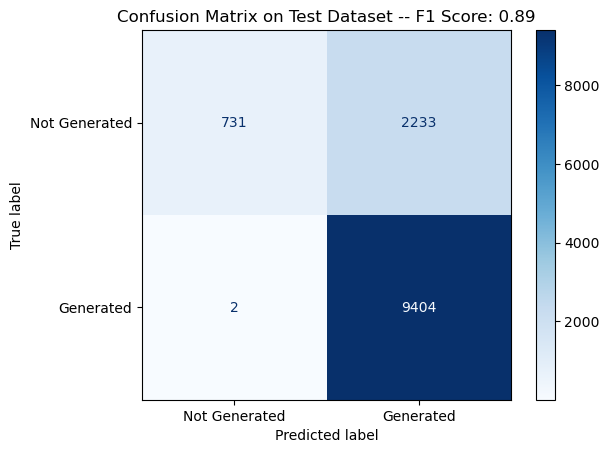

In [124]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
displayConfusionMatrix(y_test, y_pred,  "Test")
plt.savefig('confusion_matrix_test_results.png')